In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import json
import pybedtools
from scipy.stats import ranksums, ttest_ind
import time
from pprint import pprint
import itertools
from collections import Counter
from plotly.subplots import make_subplots
import umap

In [2]:
organ_list = []
with open('../../benchmarking/data/organ_list.txt') as f:
    for line in f:
        organ_list.append(line.strip())
organ_list.remove('bodily_fluid')
organ_list.remove('paraythroid_gland')
len(organ_list)

51

### 1. Prepare data

In [3]:
# Read locID to trait mapping
with open('../data/GWAS_catalog/rsID_mapped_trait.json') as f:
    rsID_trait = json.load(f)
rsID_trait

{'12:112049014': {'Mapped_trait': ['type I diabetes mellitus',
   'type I diabetes mellitus',
   'type I diabetes mellitus',
   'total cholesterol measurement',
   'total cholesterol measurement',
   'stroke',
   'high density lipoprotein cholesterol measurement',
   'high density lipoprotein cholesterol measurement',
   'low density lipoprotein cholesterol measurement',
   'low density lipoprotein cholesterol measurement',
   'mean arterial pressure',
   'diastolic blood pressure, alcohol drinking',
   'diastolic blood pressure, alcohol drinking',
   'mean arterial pressure, alcohol drinking',
   'parental longevity',
   'glomerular filtration rate',
   'systolic blood pressure, alcohol drinking',
   'urate measurement',
   'coronary artery disease',
   'urate measurement'],
  'Mapped_trait_URL': ['http://www.ebi.ac.uk/efo/EFO_0001359',
   'http://www.ebi.ac.uk/efo/EFO_0001359',
   'http://www.ebi.ac.uk/efo/EFO_0001359',
   'http://www.ebi.ac.uk/efo/EFO_0004574',
   'http://www.ebi.ac

In [4]:
# Number of variants for each trait
trait_num_rsID = dict()
with open('../data/GWAS_catalog/trait_snps_stats_recount.txt') as f2:
    for line in f2:
        trait_num_rsID[line.strip().split('\t')[0]] = int(line.strip().split('\t')[1])
trait_num_rsID_sorted = {k: v for k, v in sorted(trait_num_rsID.items(), key=lambda item: item[1],reverse=True)}
trait_num_rsID_sorted

{'acute myeloid leukemia': 7536,
 'body mass index': 4434,
 'body height': 4385,
 'response to bronchodilator': 3460,
 'FEV/FEC ratio': 3127,
 'self reported educational attainment': 3088,
 'heel bone mineral density': 2909,
 'blood protein measurement': 2789,
 'intelligence': 2670,
 'schizophrenia': 2606,
 'systolic blood pressure': 2197,
 'mathematical ability': 2129,
 'BMI-adjusted waist-hip ratio': 1997,
 'high density lipoprotein cholesterol measurement': 1977,
 'triglyceride measurement': 1785,
 'unipolar depression': 1781,
 'forced expiratory volume': 1757,
 'type II diabetes mellitus': 1737,
 'BMI-adjusted waist circumference': 1687,
 'smoking status measurement': 1614,
 'asthma': 1451,
 'low density lipoprotein cholesterol measurement': 1432,
 'neuroticism measurement': 1391,
 'adolescent idiopathic scoliosis': 1370,
 'eosinophil count': 1296,
 'diastolic blood pressure': 1279,
 'waist-hip ratio': 1227,
 'glomerular filtration rate': 1177,
 'mean corpuscular hemoglobin': 1168,

In [5]:
# Read json object of variants in strong LD
with open('../data/GWAS_catalog/variants_LD_pairs_R2_0.6.json') as f:
    LD_paris = json.load(f)
with open('../data/GWAS_catalog/variants_LD_pairs_R2_0.8.json') as f:
    LD_paris_08 = json.load(f)
with open('../data/GWAS_catalog/variants_LD_pairs_R2_0.99.json') as f:
    LD_paris_099 = json.load(f)
with open('../data/GWAS_catalog/variants_LD_pairs_R2_1.0.json') as f:
    LD_paris_10 = json.load(f)
LD_paris

{'1:845017': ['1:796784', '1:804610'],
 '1:832873': ['1:873251', '1:873548'],
 '1:946653': ['1:933923',
  '1:935954',
  '1:936972',
  '1:941767',
  '1:954724',
  '1:964825',
  '1:965125',
  '1:968046'],
 '1:959193': ['1:940263',
  '1:942335',
  '1:951408',
  '1:954258',
  '1:954333',
  '1:958251',
  '1:958339',
  '1:961945',
  '1:962184',
  '1:962358',
  '1:964905',
  '1:965350',
  '1:966179',
  '1:966227',
  '1:967617'],
 '1:973929': ['1:973443',
  '1:976215',
  '1:976536',
  '1:978230',
  '1:981282',
  '1:982112',
  '1:982890',
  '1:983237'],
 '1:999842': ['1:979560',
  '1:981454',
  '1:983004',
  '1:983193',
  '1:986336',
  '1:995153',
  '1:995187',
  '1:995371',
  '1:995512',
  '1:995786',
  '1:995982',
  '1:998410',
  '1:1000731',
  '1:1004625',
  '1:1004716',
  '1:1005904',
  '1:1005954',
  '1:1006159',
  '1:1008307',
  '1:1008588',
  '1:1009184',
  '1:1014228',
  '1:1014863',
  '1:1015297',
  '1:1015903',
  '1:1016184',
  '1:1016623',
  '1:1017048',
  '1:1018572',
  '1:1019397',

In [6]:
# Read organSp scores
df_scores_tland = pd.read_csv('../data/gwas_prediction/TLand.txt',sep='\t') #new struct
#add unique ID: rsID-alt
df_scores_tland['locID-alt'] = df_scores_tland['name'] + '-' + df_scores_tland['alt']
df_scores_tland = df_scores_tland.drop_duplicates()
df_scores_tland.head()

chrom     end      name ref alt  adrenal gland  arterial blood vessel  \
0  chr1  796784  1:796784   T   G       0.185707               0.125367   
1  chr1  804610  1:804610   G   A       0.138573               0.130520   
2  chr1  832873  1:832873   A   C       0.148267               0.120813   
3  chr1  845017  1:845017   C   T       0.152550               0.132863   
4  chr1  873251  1:873251   G   A       0.124413               0.133621   

      blood  blood vessel  bone element  ...    spleen   stomach    testis  \
0  0.121808      0.127487      0.454381  ...  0.123535  0.122958  0.112688   
1  0.192186      0.144655      0.562951  ...  0.136801  0.148886  0.138150   
2  0.120997      0.122038      0.131011  ...  0.207055  0.183152  0.156703   
3  0.127466      0.126910      0.125643  ...  0.131511  0.143008  0.140270   
4  0.128390      0.128155      0.122319  ...  0.127063  0.121832  0.124275   

     thymus  thyroid gland    uterus    vagina  vasculature  adipose tissue  \
0  0.119901       0.125966  0.123657  0.188410     0.122221        0.126280   
1  0.148908       0.409593  0.178849  0.190549     0.170705        0.141008   
2  0.138399       0.149609  0.129667  0.323368     0.128568        0.121847   
3  0.134000       0.206566  0.146006  0.209315     0.125540        0.193465   
4  0.126989       0.126836  0.133691  0.144049     0.125927        0.131483   

    locID-alt  
0  1:796784-G  
1  1:804610-A  
2  1:832873-C  
3  1:845017-T  
4  1:873251-A  

[5 rows x 57 columns]

In [7]:
# Read organSp scores
df_scores_tland_light = pd.read_csv('../data/gwas_prediction/TLand_light.txt',sep='\t') #new struct
#add unique ID: rsID-alt
df_scores_tland_light['locID-alt'] = df_scores_tland_light['name'] + '-' + df_scores_tland_light['alt']
df_scores_tland_light = df_scores_tland_light.drop_duplicates()
df_scores_tland_light.head()

chrom     end      name ref alt  adrenal gland  arterial blood vessel  \
0  chr1  796784  1:796784   T   G       0.207276               0.131966   
1  chr1  804610  1:804610   G   A       0.136011               0.140733   
2  chr1  832873  1:832873   A   C       0.147494               0.125696   
3  chr1  845017  1:845017   C   T       0.161665               0.151006   
4  chr1  873251  1:873251   G   A       0.124270               0.134928   

      blood  blood vessel  bone element  ...    spleen   stomach    testis  \
0  0.124367      0.129588      0.558973  ...  0.128334  0.130851  0.130029   
1  0.195999      0.164347      0.563631  ...  0.153784  0.159852  0.146452   
2  0.122307      0.133251      0.143397  ...  0.230803  0.179273  0.165658   
3  0.138197      0.135102      0.125024  ...  0.154825  0.145600  0.149968   
4  0.124575      0.129063      0.123728  ...  0.125775  0.125015  0.123788   

     thymus  thyroid gland    uterus    vagina  vasculature  adipose tissue  \
0  0.129600       0.131963  0.140598  0.204339     0.132102        0.142579   
1  0.177808       0.400841  0.220669  0.212806     0.169316        0.174163   
2  0.154499       0.193421  0.149754  0.280146     0.130899        0.143124   
3  0.160854       0.216758  0.148708  0.238541     0.127993        0.184999   
4  0.127620       0.129744  0.130971  0.147366     0.124143        0.140302   

    locID-alt  
0  1:796784-G  
1  1:804610-A  
2  1:832873-C  
3  1:845017-T  
4  1:873251-A  

[5 rows x 57 columns]

In [8]:
# Read organSp scores
df_scores_tland_lightest = pd.read_csv('../data/gwas_prediction/TLand_lightest.txt',sep='\t') #new struct
#add unique ID: rsID-alt
df_scores_tland_lightest['locID-alt'] = df_scores_tland_lightest['name'] + '-' + df_scores_tland_lightest['alt']
df_scores_tland_lightest = df_scores_tland_lightest.drop_duplicates()
df_scores_tland_lightest.head()

chrom     end      name ref alt  adrenal gland  arterial blood vessel  \
0  chr1  796784  1:796784   T   G       0.213080               0.152855   
1  chr1  804610  1:804610   G   A       0.173143               0.173148   
2  chr1  832873  1:832873   A   C       0.172631               0.140059   
3  chr1  845017  1:845017   C   T       0.137814               0.134707   
4  chr1  873251  1:873251   G   A       0.178290               0.350676   

      blood  blood vessel  bone element  ...    spleen   stomach    testis  \
0  0.133286      0.133867      0.131281  ...  0.215328  0.138033  0.188151   
1  0.164264      0.206409      0.217460  ...  0.193790  0.244031  0.189407   
2  0.134371      0.147958      0.150887  ...  0.214208  0.232968  0.218487   
3  0.126444      0.123456      0.120278  ...  0.132870  0.129705  0.137062   
4  0.263899      0.193019      0.194463  ...  0.156772  0.178577  0.215369   

     thymus  thyroid gland    uterus    vagina  vasculature  adipose tissue  \
0  0.182541       0.155927  0.129871  0.241735     0.128640        0.284113   
1  0.320306       0.280633  0.330058  0.347957     0.238495        0.204757   
2  0.194890       0.352541  0.191329  0.357886     0.154312        0.163374   
3  0.150123       0.174728  0.131355  0.173969     0.128648        0.153459   
4  0.168662       0.337109  0.185001  0.325659     0.188908        0.430525   

    locID-alt  
0  1:796784-G  
1  1:804610-A  
2  1:832873-C  
3  1:845017-T  
4  1:873251-A  

[5 rows x 57 columns]

#### visualize organs

##### score distribution

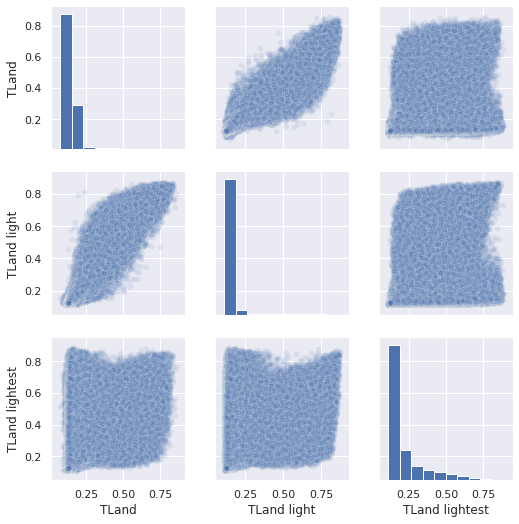

In [18]:
sns.pairplot(pd.concat([df_scores_tland['heart'].rename('TLand'), df_scores_tland_light['heart'].rename('TLand light'), df_scores_tland_lightest['heart'].rename('TLand lightest')], 
          axis=1), plot_kws=dict(alpha=0.1))

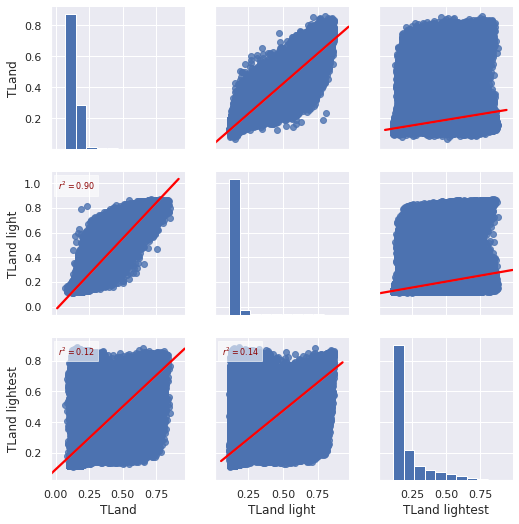

In [30]:
from scipy.stats import linregress
def r2(x, y, ax=None, **kws):
    ax = ax or plt.gca()
    _, _, r_value, _, _ = linregress(x=x, y=y)
    ax.annotate(f'$r^2 = {r_value ** 2:.2f}$',
                xy=(.05, .95), xycoords=ax.transAxes, fontsize=8,
                color='darkred', backgroundcolor='#FFFFFF99', ha='left', va='top')

g= sns.pairplot(pd.concat([df_scores_tland['heart'].rename('TLand'), df_scores_tland_light['heart'].rename('TLand light'), df_scores_tland_lightest['heart'].rename('TLand lightest')], 
          axis=1), kind='reg', plot_kws={'line_kws':{'color':'red'}})

g.map_lower(r2)
plt.savefig('../plots/heart_score_distr.svg', dpi=1000, bbox_inches='tight')

##### UMAP

In [9]:
system_dict = pd.read_csv('../data/organ_system.txt', sep=',', header=None).set_index(0).to_dict()[1]
system_ls = pd.read_csv('../data/organ_system.txt', sep=',', header=None)[1].unique().tolist()

In [42]:
model = df_scores_tland
random_state=828148
embedding = umap.UMAP(random_state=random_state).fit_transform(model.iloc[:, 5:-1].T)
principalDf = pd.DataFrame(data = embedding
             , columns = ['UMAP 1', 'UMAP 2'])

col_names = model.iloc[:, 5:-1].columns
principalDf.set_index(col_names, inplace=True)
principalDf.reset_index(inplace=True)
principalDf['system'] = principalDf['index'].apply(lambda x: system_dict[x])

distance_ls = []
score_sum = 0
for system in system_ls:
    if (system != 'others') and (';' not in system):
        temp_df = principalDf.loc[principalDf['system'].str.contains(system), :]
        distance_score = ((temp_df[['UMAP 1', 'UMAP 2']] - temp_df[['UMAP 1', 'UMAP 2']].mean())**2).sum(axis=1).sum()
        score_sum+=distance_score
        distance_ls.append([system, distance_score])
print(score_sum)

56.14262943714857


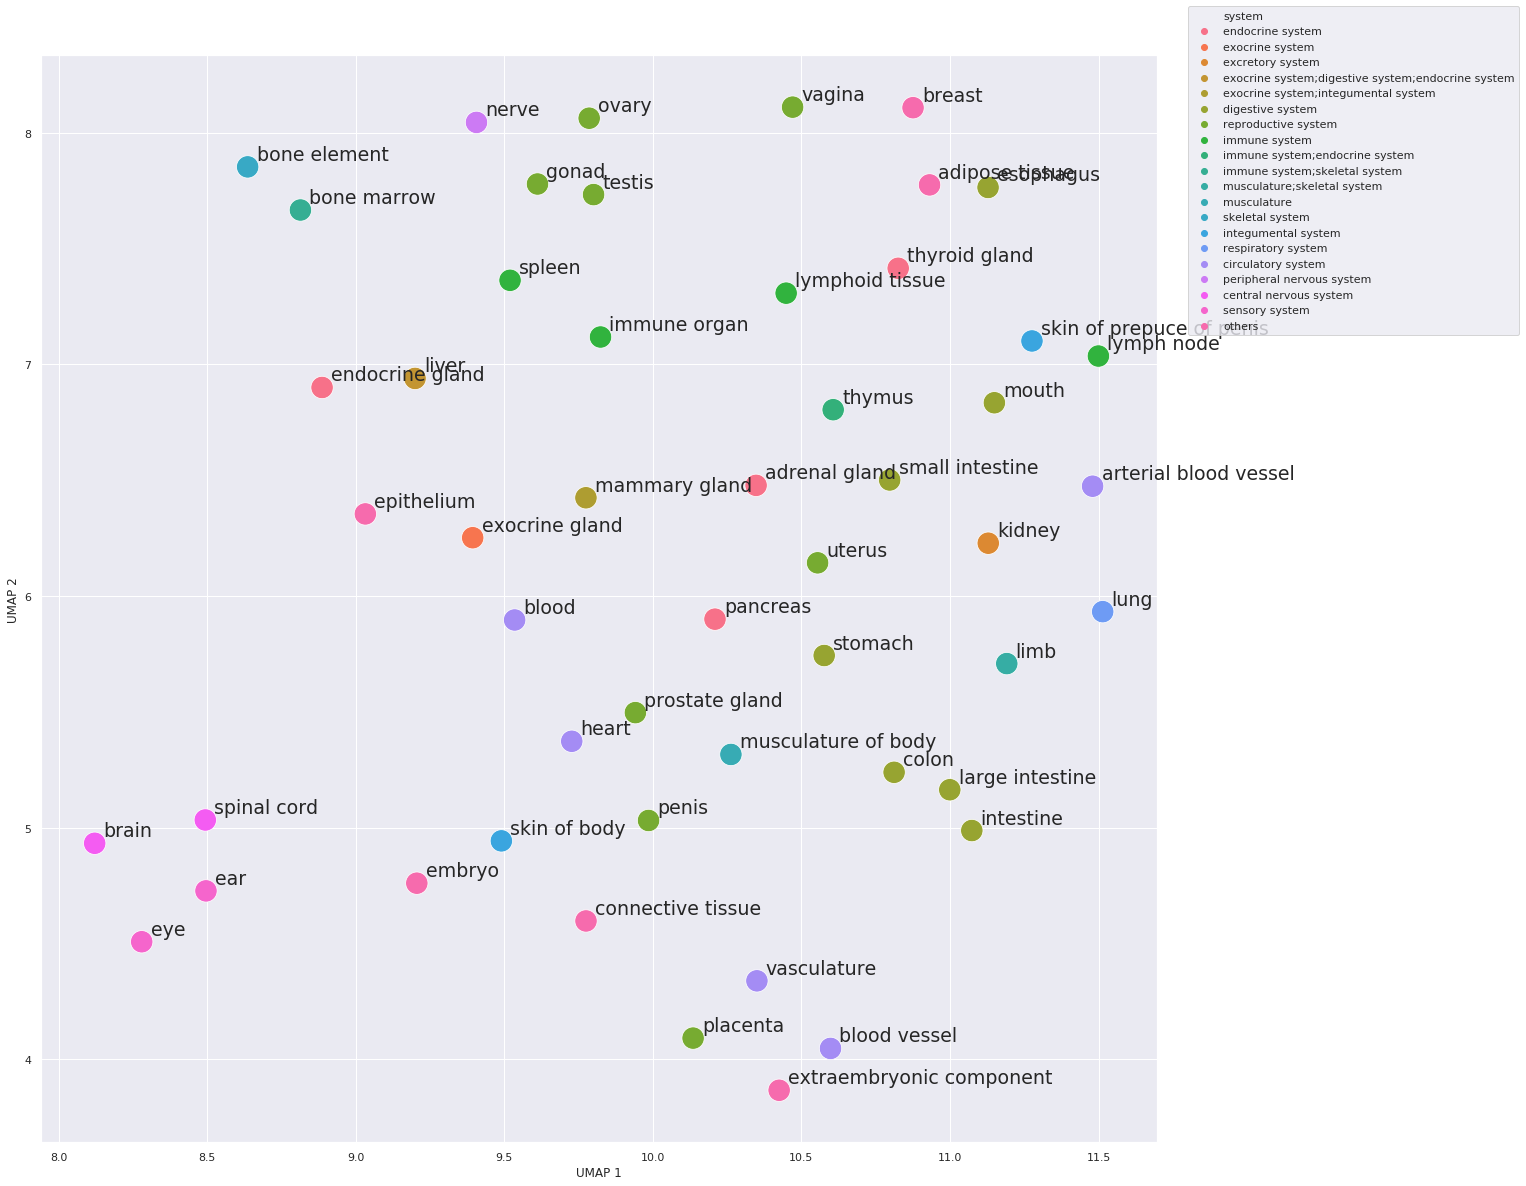

In [49]:
sns.set(rc={'figure.figsize':(20,20)})
sns.scatterplot(x= 'UMAP 1', y='UMAP 2', hue='system', hue_order=['endocrine system',
                                                                    'exocrine system',
                                                                    'excretory system',
                                                                    'exocrine system;digestive system;endocrine system',
                                                                    'exocrine system;integumental system',
                                                                    'digestive system',
                                                                    'reproductive system',
                                                                    'immune system',
                                                                    'immune system;endocrine system', 
                                                                    'immune system;skeletal system',
                                                                    'musculature;skeletal system',
                                                                    'musculature',
                                                                    'skeletal system',
                                                                    'integumental system',
                                                                    'respiratory system',
                                                                    'circulatory system',
                                                                    'peripheral nervous system',
                                                                    'central nervous system',
                                                                    'sensory system',
                                                                    'others'], data=principalDf, s=500)
plt.legend(bbox_to_anchor=(1.33, 1.05))
for i in range(principalDf.shape[0]):
    plt.annotate(principalDf['index'][i], (principalDf['UMAP 1'][i] + 0.03, principalDf['UMAP 2'][i] + 0.03), fontsize=19)
plt.savefig('../plots/tland_umap_largertext.svg', dpi=1000, bbox_inches='tight')

In [10]:
model = df_scores_tland_light
random_state=247806
embedding = umap.UMAP(random_state=random_state).fit_transform(model.iloc[:, 5:-1].T)
principalDf = pd.DataFrame(data = embedding
             , columns = ['UMAP 1', 'UMAP 2'])

col_names = model.iloc[:, 5:-1].columns
principalDf.set_index(col_names, inplace=True)
principalDf.reset_index(inplace=True)
principalDf['system'] = principalDf['index'].apply(lambda x: system_dict[x])

distance_ls = []
score_sum = 0
for system in system_ls:
    if (system != 'others') and (';' not in system):
        temp_df = principalDf.loc[principalDf['system'].str.contains(system), :]
        distance_score = ((temp_df[['UMAP 1', 'UMAP 2']] - temp_df[['UMAP 1', 'UMAP 2']].mean())**2).sum(axis=1).sum()
        score_sum+=distance_score
        distance_ls.append([system, distance_score])
print(score_sum)

57.68887837976217


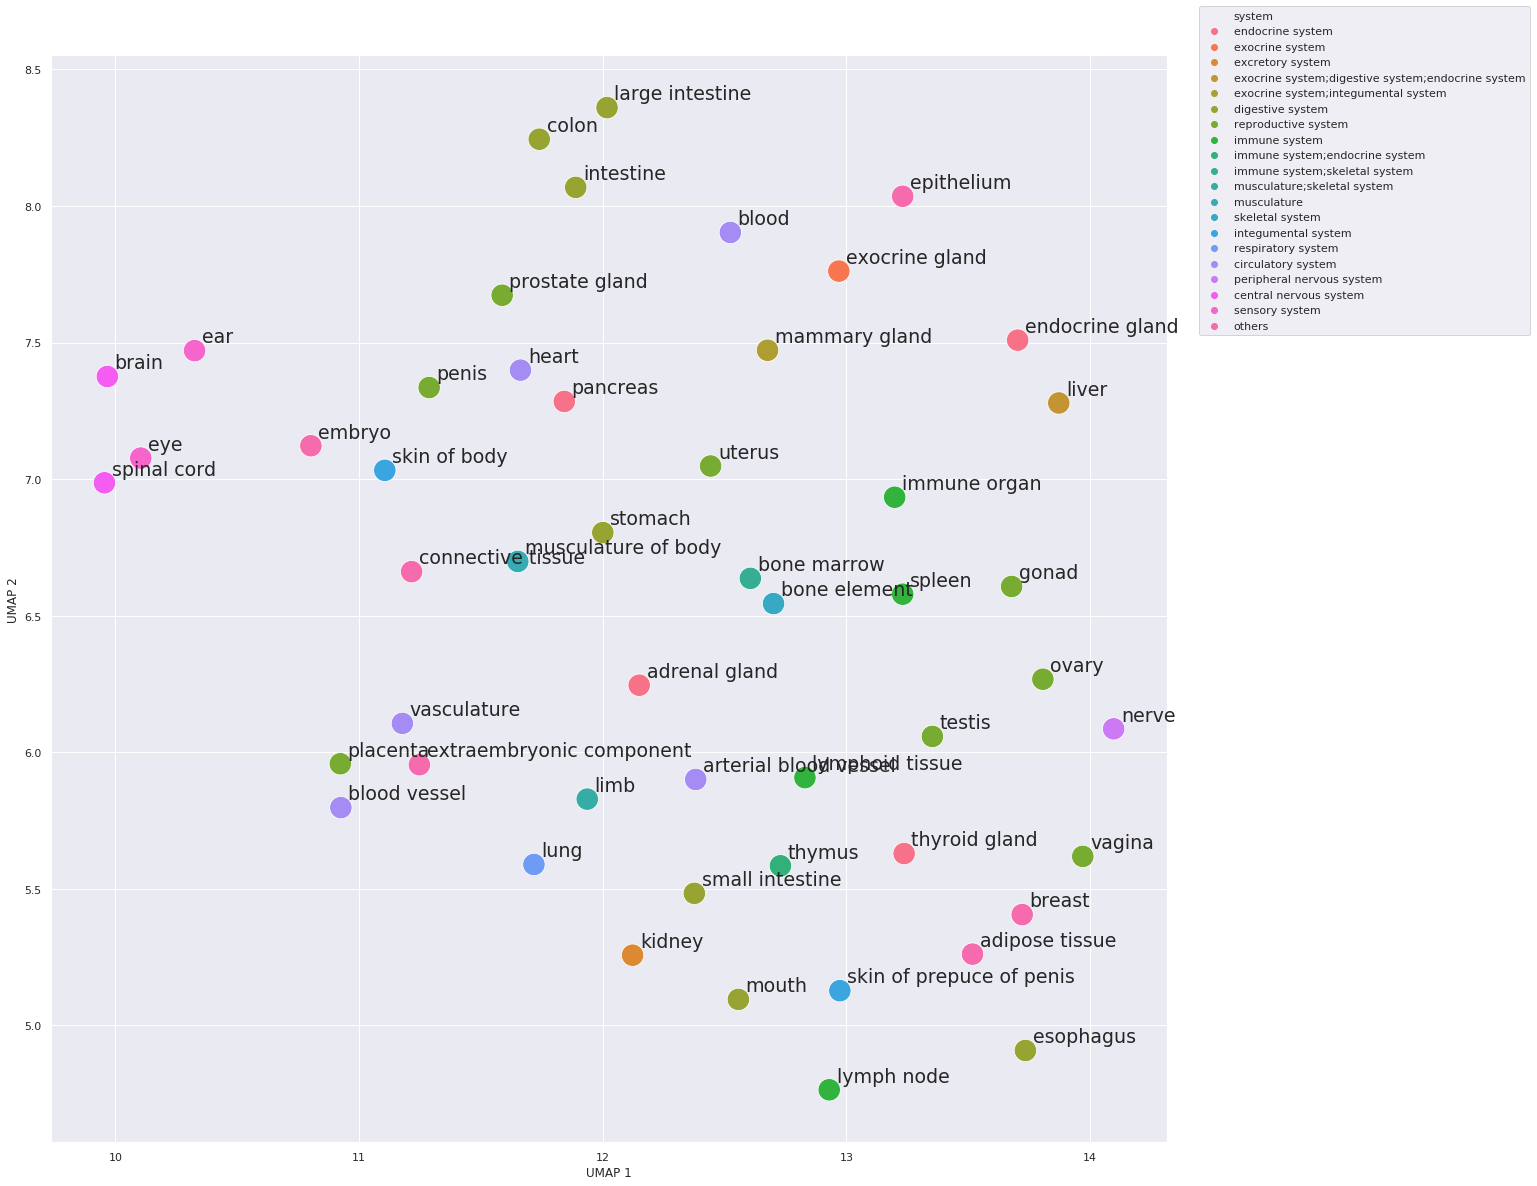

In [11]:
sns.set(rc={'figure.figsize':(20,20)})
sns.scatterplot(x= 'UMAP 1', y='UMAP 2', hue='system', hue_order=['endocrine system',
                                                                    'exocrine system',
                                                                    'excretory system',
                                                                    'exocrine system;digestive system;endocrine system',
                                                                    'exocrine system;integumental system',
                                                                    'digestive system',
                                                                    'reproductive system',
                                                                    'immune system',
                                                                    'immune system;endocrine system', 
                                                                    'immune system;skeletal system',
                                                                    'musculature;skeletal system',
                                                                    'musculature',
                                                                    'skeletal system',
                                                                    'integumental system',
                                                                    'respiratory system',
                                                                    'circulatory system',
                                                                    'peripheral nervous system',
                                                                    'central nervous system',
                                                                    'sensory system',
                                                                    'others'], data=principalDf, s=500)
plt.legend(bbox_to_anchor=(1.33, 1.05))
for i in range(principalDf.shape[0]):
    plt.annotate(principalDf['index'][i], (principalDf['UMAP 1'][i] + 0.03, principalDf['UMAP 2'][i] + 0.03), fontsize=19)
plt.savefig('../plots/tland_light_umap_largertext.svg', dpi=1000, bbox_inches='tight')

In [12]:
model = df_scores_tland_lightest
random_state=43702
embedding = umap.UMAP(random_state=random_state).fit_transform(model.iloc[:, 5:-1].T)
principalDf = pd.DataFrame(data = embedding
             , columns = ['UMAP 1', 'UMAP 2'])

col_names = model.iloc[:, 5:-1].columns
principalDf.set_index(col_names, inplace=True)
principalDf.reset_index(inplace=True)
principalDf['system'] = principalDf['index'].apply(lambda x: system_dict[x])

distance_ls = []
score_sum = 0
for system in system_ls:
    if (system != 'others') and (';' not in system):
        temp_df = principalDf.loc[principalDf['system'].str.contains(system), :]
        distance_score = ((temp_df[['UMAP 1', 'UMAP 2']] - temp_df[['UMAP 1', 'UMAP 2']].mean())**2).sum(axis=1).sum()
        score_sum+=distance_score
        distance_ls.append([system, distance_score])
print(score_sum)

105.92132297158241


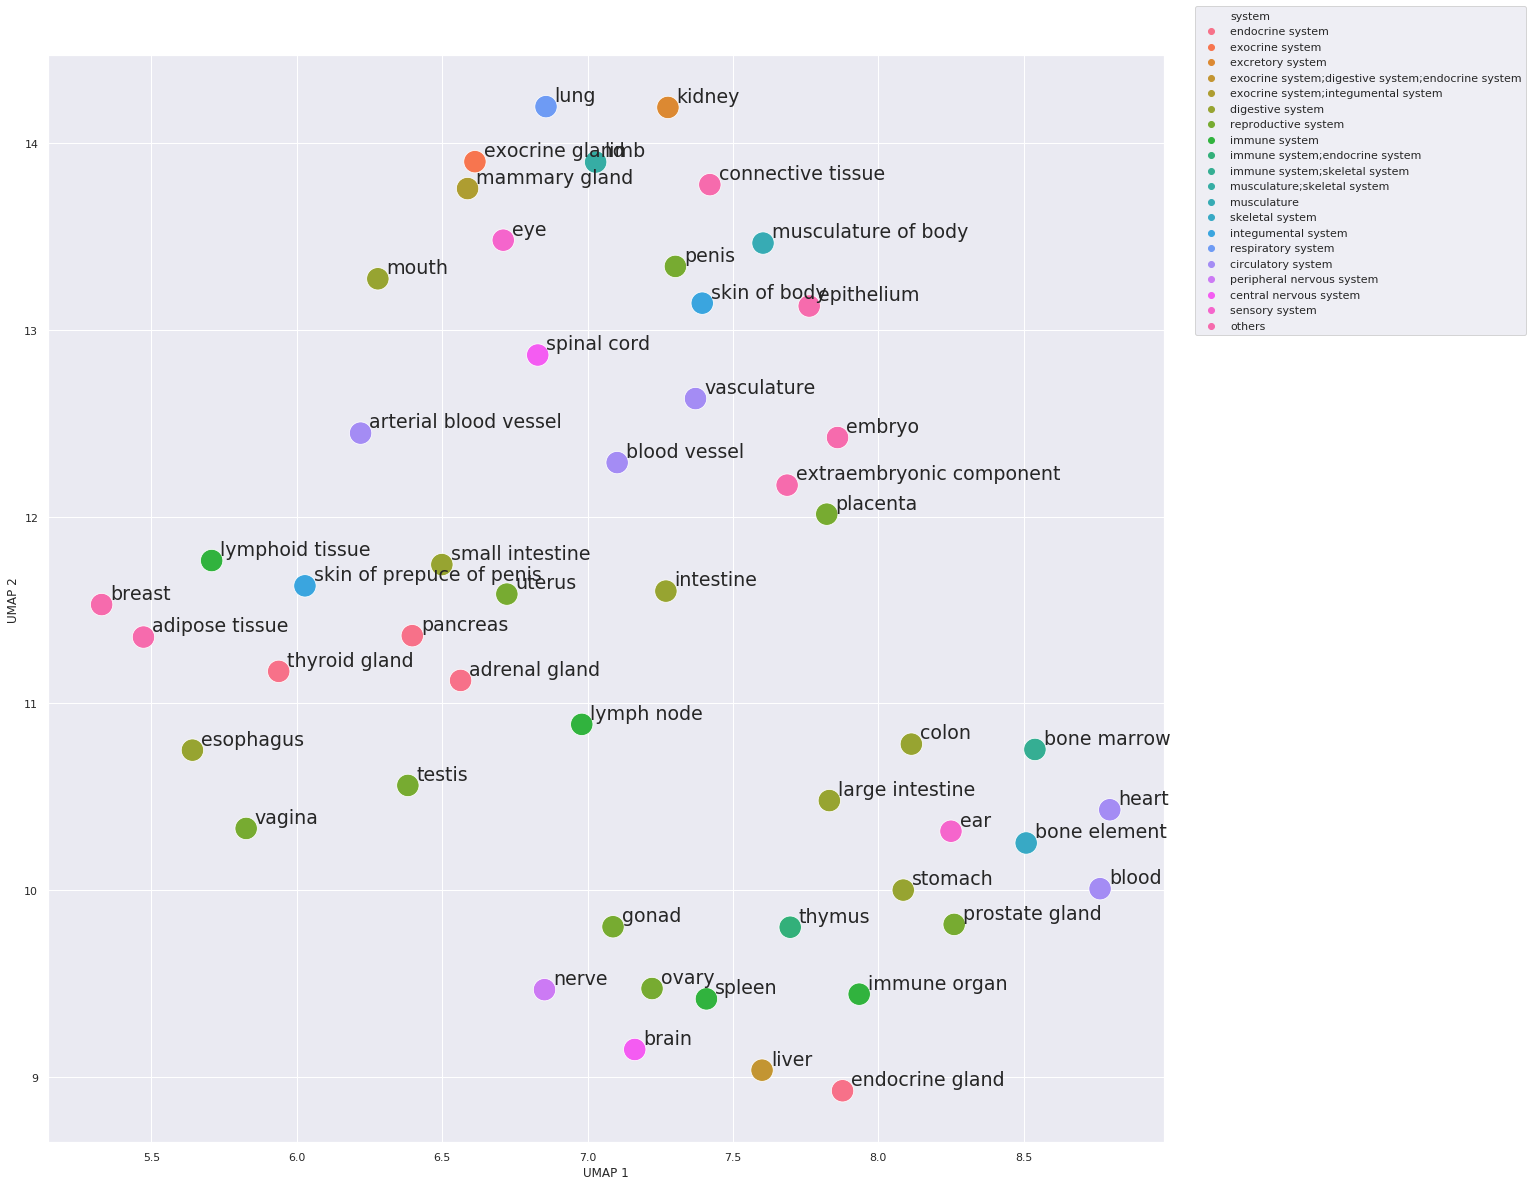

In [13]:
sns.set(rc={'figure.figsize':(20,20)})
sns.scatterplot(x= 'UMAP 1', y='UMAP 2', hue='system', hue_order=['endocrine system',
                                                                    'exocrine system',
                                                                    'excretory system',
                                                                    'exocrine system;digestive system;endocrine system',
                                                                    'exocrine system;integumental system',
                                                                    'digestive system',
                                                                    'reproductive system',
                                                                    'immune system',
                                                                    'immune system;endocrine system', 
                                                                    'immune system;skeletal system',
                                                                    'musculature;skeletal system',
                                                                    'musculature',
                                                                    'skeletal system',
                                                                    'integumental system',
                                                                    'respiratory system',
                                                                    'circulatory system',
                                                                    'peripheral nervous system',
                                                                    'central nervous system',
                                                                    'sensory system',
                                                                    'others'], data=principalDf, s=500)
plt.legend(bbox_to_anchor=(1.33, 1.05))
for i in range(principalDf.shape[0]):
    plt.annotate(principalDf['index'][i], (principalDf['UMAP 1'][i] + 0.03, principalDf['UMAP 2'][i] + 0.03), fontsize=19)
plt.savefig('../plots/tland_lightest_umap_largertext.svg', dpi=1000, bbox_inches='tight')

### 2. Trait-focused example

#### configuration search

In [26]:
selected_gwas = pd.read_csv('../data/Select GWAS traits.csv')
traits = selected_gwas['Trait'].tolist()
target_organs = selected_gwas['Target Organ(s)'].tolist()
selected_gwas

Unnamed: 0                                             Trait  # lead SNPs  \
0            0                                   body mass index         4434   
1            1                 red blood cell distribution width          989   
2            2                                  eosinophil count         1296   
3            3                              mean platelet volume          343   
4            4                                      bone density          408   
5            5                  bone mineral content measurement           78   
6            6                                       body height         4385   
7            7                    depressive symptom measurement          503   
8            8                               unipolar depression         1781   
9            9                          brain volume measurement          784   
10          10                                  breast carcinoma         1085   
11          11                                 colorectal cancer          606   
12          12                                   Crohn's disease          749   
13          13                                ulcerative colitis          559   
14          14                                    osteoarthritis          262   
15          15                              rheumatoid arthritis          520   
16          16                                      birth weight          499   
17          17                                         psoriasis          543   
18          18                                cutaneous melanoma          248   
19          19                       optic disc size measurement          165   
20          20                               atrial fibrillation          385   
21          21                                       QT interval          271   
22          22                           coronary artery disease          775   
23          23                            mean arterial pressure          385   
24          24                                       PR interval          469   
25          25                            cardiovascular disease          331   
26          26                            coronary heart disease          233   
27          27                           systolic blood pressure         2197   
28          28                        glomerular filtration rate         1177   
29          29                            chronic kidney disease          530   
30          30                   alcohol consumption measurement          938   
31          31  high density lipoprotein cholesterol measurement         1977   
32          32   low density lipoprotein cholesterol measurement         1432   
33          33                     total cholesterol measurement          884   
34          34                        respiratory system disease          109   
35          35                               lung adenocarcinoma          179   
36          36                                    lung carcinoma          382   
37          37                      squamous cell lung carcinoma          206   
38          38                                           allergy          267   
39          39                                autoimmune disease          164   
40          40                            ankylosing spondylitis          381   
41          41                                 ovarian carcinoma          281   
42          42                            alcoholic pancreatitis          140   
43          43                         type II diabetes mellitus         1737   
44          44                          type I diabetes mellitus          280   
45          45                              pancreatic carcinoma          158   
46          46                                prostate carcinoma          463   
47          47                        spine bone mineral density           83   
48          48                     

In [6]:
def rank_test(population_df, sample_df, threshold=0.05):
    rank_test_ls = []
    
    for organ in organ_list:
        organ = organ.replace('_', ' ')
        sample1 = population_df[organ]
        sample2 = sample_df[organ]
        rank_test_ls.append([organ, ranksums(sample1, sample2, alternative='less').pvalue])
    
    result_df = pd.DataFrame(rank_test_ls).sort_values([1])
    result_df = result_df.loc[result_df[1] < threshold, :]
    if result_df.shape[0] == 0:
        result_df = pd.DataFrame(rank_test_ls).sort_values([1]).head(3)
    top_organs = result_df[0].tolist()
    pvalues = result_df[1].tolist()
    
    return top_organs, pvalues

def t_test(population_df, sample_df, threshold=0.05):
    t_test_ls = []
    
    for organ in organ_list:
        organ = organ.replace('_', ' ')
        sample1 = population_df[organ]
        sample2 = sample_df[organ]
        t_test_ls.append([organ, ttest_ind(sample1, sample2, alternative='less').pvalue])
    
    result_df = pd.DataFrame(t_test_ls).sort_values([1])
    result_df = result_df.loc[result_df[1] < threshold, :]
    if result_df.shape[0] == 0:
        result_df = pd.DataFrame(t_test_ls).sort_values([1]).head(3)
    top_organs = result_df[0].tolist()
    pvalues = result_df[1].tolist()
    
    return top_organs, pvalues

def keep_highest_score_per_window(df_input, window_size=1000000):
    df_rsID_hits_scores_LD_2 = df_input[['locID-alt','chrom','end'] + [organ.replace('_', ' ') for organ in organ_list]].melt(id_vars=['locID-alt','chrom','end'])
    df_rsID_hits_scores_LD_2.columns = ['locID-alt','chrom','end','organ','score']
    #get highest scores
    df_rsID_hits_highest_scores = pd.DataFrame(columns = ['locID-alt','chrom','end','organ','score'])
    for organ in organ_list:
        organ = organ.replace('_', ' ')
        #print (organ)
        df_temp = df_rsID_hits_scores_LD_2.loc[df_rsID_hits_scores_LD_2['organ']==organ].sort_values(by=['score'],ascending=False).copy()
        df_temp_retain = pd.DataFrame(columns = ['locID-alt','chrom','end','organ','score'])
        for ID,chrom,end,organ,score in zip(df_temp['locID-alt'],df_temp['chrom'],df_temp['end'],df_temp['organ'],df_temp['score']):
            for ID_retain,chrom_retain,end_retain in zip(df_temp_retain['locID-alt'],df_temp_retain['chrom'],df_temp_retain['end']):
                if chrom == chrom_retain and abs(end-end_retain) <= window_size:
                    break #move to next variant, first FOR
            else: #no already retained variant found within 1Mb
                row_retain = pd.Series([ID,chrom,end,organ,score], index = df_temp_retain.columns)
                df_temp_retain = df_temp_retain.append(row_retain,ignore_index=True)
        df_rsID_hits_highest_scores = pd.concat([df_rsID_hits_highest_scores,df_temp_retain],axis=0)
    return df_rsID_hits_highest_scores

def rank_test_for_refine(population_df, sample_df, threshold=0.05):
    rank_test_ls = []
    
    for organ in organ_list:
        organ = organ.replace('_', ' ')
        sample1 = population_df.loc[population_df['organ'] == organ, 'score']
        sample2 = sample_df.loc[sample_df['organ'] == organ, 'score']
        rank_test_ls.append([organ, ranksums(sample1, sample2, alternative='less').pvalue])
    
    result_df = pd.DataFrame(rank_test_ls).sort_values([1])
    result_df = result_df.loc[result_df[1] < threshold, :]
    if result_df.shape[0] == 0:
        result_df = pd.DataFrame(rank_test_ls).sort_values([1]).head(3)
    top_organs = result_df[0].tolist()
    pvalues = result_df[1].tolist()
    
    return top_organs, pvalues

def t_test_for_refine(population_df, sample_df, threshold=0.05):
    t_test_ls = []
    
    for organ in organ_list:
        organ = organ.replace('_', ' ')
        sample1 = population_df.loc[population_df['organ'] == organ, 'score']
        sample2 = sample_df.loc[sample_df['organ'] == organ, 'score']
        t_test_ls.append([organ, ttest_ind(sample1, sample2, alternative='less').pvalue])
    
    result_df = pd.DataFrame(t_test_ls).sort_values([1])
    result_df = result_df.loc[result_df[1] < threshold, :]
    if result_df.shape[0] == 0:
        result_df = pd.DataFrame(t_test_ls).sort_values([1]).head(3)
    top_organs = result_df[0].tolist()
    pvalues = result_df[1].tolist()
    
    return top_organs, pvalues

In [12]:
config_search_ls = []
df_scores_tland_refine = pd.read_csv('../data/gwas_prediction/TLand_refine.txt',sep='\t')
df_scores_tland_light_refine = pd.read_csv('../data/gwas_prediction/TLand_light_refine.txt',sep='\t')
df_scores_tland_lightest_refine = pd.read_csv('../data/gwas_prediction/TLand_lightest_refine.txt',sep='\t')

for trait, target_organ in zip(traits[:1], target_organs[:1]):
    print(trait)
    start_time = time.time()
    target_organ = [item.strip() for item in target_organ.split(',')]

    # lead SNPs
    rsID_hits = []
    for rsID in rsID_trait.keys():
        if trait in rsID_trait[rsID]['Mapped_trait']:
            rsID_hits.append(rsID)
    df_rsID_hits_leading = pd.DataFrame(list(set(rsID_hits)),columns = ['name'])

    for model_name, scores in zip(['tland', 'tland_light', 'tland_lightest'], 
                                    [df_scores_tland, df_scores_tland_light, df_scores_tland_lightest]):
        df_rsID_hits_scores_leading =  pd.merge(scores, df_rsID_hits_leading, how='outer', indicator=True)

        population_df = df_rsID_hits_scores_leading.loc[df_rsID_hits_scores_leading['_merge'] == 'left_only', :]
        df_rsID_hits_scores_leading = df_rsID_hits_scores_leading.loc[df_rsID_hits_scores_leading['_merge'] == 'both', :]
        
        top_organs, pvalues = rank_test(population_df=population_df, sample_df=df_rsID_hits_scores_leading)
        config_search_ls.append([trait, df_rsID_hits_scores_leading.shape[0], model_name, 'rank_test', 'NoLD', 'NoRefine', top_organs, pvalues, target_organ])
        
        top_organs, pvalues = t_test(population_df=population_df, sample_df=df_rsID_hits_scores_leading)
        config_search_ls.append([trait, df_rsID_hits_scores_leading.shape[0], model_name, 't_test', 'NoLD', 'NoRefine', top_organs, pvalues, target_organ])


    # lead SNPs + variants in LD
    rsID_hits_LD = []
    for rsID in rsID_hits:
        if rsID in LD_paris.keys():
            rsID_hits_LD.extend(LD_paris[rsID])
    df_rsID_hits_leading = pd.DataFrame(list(set(rsID_hits + rsID_hits_LD)),columns = ['name']) # didn't change the name, but should be leading + LD

    for model_name, scores in zip(['tland', 'tland_light', 'tland_lightest'], 
                                    [df_scores_tland, df_scores_tland_light, df_scores_tland_lightest]):
        df_rsID_hits_scores_leading =  pd.merge(scores, df_rsID_hits_leading, how='outer', indicator=True)

        population_df = df_rsID_hits_scores_leading.loc[df_rsID_hits_scores_leading['_merge'] == 'left_only', :]
        df_rsID_hits_scores_leading = df_rsID_hits_scores_leading.loc[df_rsID_hits_scores_leading['_merge'] == 'both', :]
        
        top_organs, pvalues = rank_test(population_df=population_df, sample_df=df_rsID_hits_scores_leading)
        config_search_ls.append([trait, df_rsID_hits_scores_leading.shape[0], model_name, 'rank_test', 'LD', 'NoRefine', top_organs, pvalues, target_organ])
        
        top_organs, pvalues = t_test(population_df=population_df, sample_df=df_rsID_hits_scores_leading)
        config_search_ls.append([trait, df_rsID_hits_scores_leading.shape[0], model_name, 't_test', 'LD', 'NoRefine', top_organs, pvalues, target_organ])


    # lead SNPs + variants in LD (0.8)
    rsID_hits_LD = []
    for rsID in rsID_hits:
        if rsID in LD_paris_08.keys():
            rsID_hits_LD.extend(LD_paris_08[rsID])
    df_rsID_hits_leading = pd.DataFrame(list(set(rsID_hits + rsID_hits_LD)),columns = ['name']) # didn't change the name, but should be leading + LD

    for model_name, scores in zip(['tland', 'tland_light', 'tland_lightest'], 
                                    [df_scores_tland, df_scores_tland_light, df_scores_tland_lightest]):
        df_rsID_hits_scores_leading =  pd.merge(scores, df_rsID_hits_leading, how='outer', indicator=True)

        population_df = df_rsID_hits_scores_leading.loc[df_rsID_hits_scores_leading['_merge'] == 'left_only', :]
        df_rsID_hits_scores_leading = df_rsID_hits_scores_leading.loc[df_rsID_hits_scores_leading['_merge'] == 'both', :]
        
        top_organs, pvalues = rank_test(population_df=population_df, sample_df=df_rsID_hits_scores_leading)
        config_search_ls.append([trait, df_rsID_hits_scores_leading.shape[0], model_name, 'rank_test', 'LD08', 'NoRefine', top_organs, pvalues, target_organ])
        
        top_organs, pvalues = t_test(population_df=population_df, sample_df=df_rsID_hits_scores_leading)
        config_search_ls.append([trait, df_rsID_hits_scores_leading.shape[0], model_name, 't_test', 'LD08', 'NoRefine', top_organs, pvalues, target_organ])


    # lead SNPs + variants in LD (0.99)
    rsID_hits_LD = []
    for rsID in rsID_hits:
        if rsID in LD_paris_099.keys():
            rsID_hits_LD.extend(LD_paris_099[rsID])
    df_rsID_hits_leading = pd.DataFrame(list(set(rsID_hits + rsID_hits_LD)),columns = ['name']) # didn't change the name, but should be leading + LD

    for model_name, scores in zip(['tland', 'tland_light', 'tland_lightest'], 
                                    [df_scores_tland, df_scores_tland_light, df_scores_tland_lightest]):
        df_rsID_hits_scores_leading =  pd.merge(scores, df_rsID_hits_leading, how='outer', indicator=True)

        population_df = df_rsID_hits_scores_leading.loc[df_rsID_hits_scores_leading['_merge'] == 'left_only', :]
        df_rsID_hits_scores_leading = df_rsID_hits_scores_leading.loc[df_rsID_hits_scores_leading['_merge'] == 'both', :]
        
        top_organs, pvalues = rank_test(population_df=population_df, sample_df=df_rsID_hits_scores_leading)
        config_search_ls.append([trait, df_rsID_hits_scores_leading.shape[0], model_name, 'rank_test', 'LD099', 'NoRefine', top_organs, pvalues, target_organ])
        
        top_organs, pvalues = t_test(population_df=population_df, sample_df=df_rsID_hits_scores_leading)
        config_search_ls.append([trait, df_rsID_hits_scores_leading.shape[0], model_name, 't_test', 'LD099', 'NoRefine', top_organs, pvalues, target_organ])


    # lead SNPs + variants in LD (1.0)
    rsID_hits_LD = []
    for rsID in rsID_hits:
        if rsID in LD_paris_10.keys():
            rsID_hits_LD.extend(LD_paris_10[rsID])
    df_rsID_hits_leading = pd.DataFrame(list(set(rsID_hits + rsID_hits_LD)),columns = ['name']) # didn't change the name, but should be leading + LD

    for model_name, scores in zip(['tland', 'tland_light', 'tland_lightest'], 
                                    [df_scores_tland, df_scores_tland_light, df_scores_tland_lightest]):
        df_rsID_hits_scores_leading =  pd.merge(scores, df_rsID_hits_leading, how='outer', indicator=True)

        population_df = df_rsID_hits_scores_leading.loc[df_rsID_hits_scores_leading['_merge'] == 'left_only', :]
        df_rsID_hits_scores_leading = df_rsID_hits_scores_leading.loc[df_rsID_hits_scores_leading['_merge'] == 'both', :]
        
        top_organs, pvalues = rank_test(population_df=population_df, sample_df=df_rsID_hits_scores_leading)
        config_search_ls.append([trait, df_rsID_hits_scores_leading.shape[0], model_name, 'rank_test', 'LD1', 'NoRefine', top_organs, pvalues, target_organ])
        
        top_organs, pvalues = t_test(population_df=population_df, sample_df=df_rsID_hits_scores_leading)
        config_search_ls.append([trait, df_rsID_hits_scores_leading.shape[0], model_name, 't_test', 'LD1', 'NoRefine', top_organs, pvalues, target_organ])
    

    # # lead SNPs + variants in LD (0.8) + refine (only one snp in 1M window)
    # rsID_hits_LD = []
    # for rsID in rsID_hits:
    #     if rsID in LD_paris_08.keys():
    #         rsID_hits_LD.extend(LD_paris_08[rsID])
    # df_rsID_hits_leading = pd.DataFrame(list(set(rsID_hits_LD)),columns = ['name']) # didn't change the name, but should be leading + LD

    # for model_name, scores, scores_refine in zip(['tland', 'tland_light', 'tland_lightest'], 
    #                                 [df_scores_tland, df_scores_tland_light, df_scores_tland_lightest], 
    #                                 [df_scores_tland_refine, df_scores_tland_light_refine, df_scores_tland_lightest_refine]):
    #     df_rsID_hits_scores_leading =  pd.merge(scores, df_rsID_hits_leading, how='outer', indicator=True)

    #     population_df = scores_refine
    #     df_rsID_hits_scores_leading = df_rsID_hits_scores_leading.loc[df_rsID_hits_scores_leading['_merge'] == 'both', :]
    #     df_rsID_hits_scores_leading = keep_highest_score_per_window(df_input=df_rsID_hits_scores_leading)
        
    #     top_organs, pvalues = rank_test_for_refine(population_df=population_df, sample_df=df_rsID_hits_scores_leading)
    #     config_search_ls.append([trait, df_rsID_hits_scores_leading.groupby(['organ'])['organ'].count().max(), model_name, 'rank_test', 'LD', 'Refine', top_organs, pvalues, target_organ])
        
    #     top_organs, pvalues = t_test_for_refine(population_df=population_df, sample_df=df_rsID_hits_scores_leading)
    #     config_search_ls.append([trait, df_rsID_hits_scores_leading.groupby(['organ'])['organ'].count().max(), model_name, 't_test', 'LD', 'Refine', top_organs, pvalues, target_organ])

    print(time.time()-start_time)
# pd.DataFrame(config_search_ls).to_csv('../data/config_search_test.csv')

body mass index
141.91422390937805


#### evaluate with piccard index

In [14]:
result_df = pd.read_csv('../data/config_search_comprehensive_part3.csv', header=None, names=['trait', '#ofSNPs', 'model', 'test', 'LD', 'Refine', 'top_organs', 'p_values', 'target_organs'])
result_df

trait  #ofSNPs           model       test    LD  \
0           body mass index   110915           tland  rank_test    LD   
1           body mass index   110915           tland     t_test    LD   
2           body mass index   110915     tland_light  rank_test    LD   
3           body mass index   110915     tland_light     t_test    LD   
4           body mass index   110915  tland_lightest  rank_test    LD   
...                     ...      ...             ...        ...   ...   
1795  endometrial carcinoma       55           tland     t_test  NoLD   
1796  endometrial carcinoma       55     tland_light  rank_test  NoLD   
1797  endometrial carcinoma       55     tland_light     t_test  NoLD   
1798  endometrial carcinoma       55  tland_lightest  rank_test  NoLD   
1799  endometrial carcinoma       55  tland_lightest     t_test  NoLD   

        Refine                                         top_organs  \
0     NoRefine  ['skin of prepuce of penis', 'spinal cord', 'b...   
1     NoRefine  ['skin of prepuce of penis', 'breast', 'vagina...   
2     NoRefine  ['skin of prepuce of penis', 'spinal cord', 't...   
3     NoRefine  ['skin of prepuce of penis', 'vagina', 'adipos...   
4     NoRefine  ['breast', 'skin of prepuce of penis', 'thyroi...   
...        ...                                                ...   
1795  NoRefine  ['large intestine', 'colon', 'intestine', 'epi...   
1796  NoRefine        ['epithelium', 'kidney', 'large intestine']   
1797  NoRefine  ['epithelium', 'intestine', 'large intestine',...   
1798  NoRefine                  ['colon', 'epithelium', 'uterus']   
1799  NoRefine                           ['epithelium', 'uterus']   

                                               p_values  \
0     [4.805303638741203e-255, 1.381250098732217e-20...   
1     [3.955120259235844e-135, 4.839982452668028e-11...   
2     [4.301491425248094e-298, 1.792178425154326e-20...   
3     [1.7406220710228325e-133, 3.999500004619858e-1...   
4     [6.51112065058792e-110, 2.883320686828924e-100...   
...                                                 ...   
1795  [0.01043791780309225, 0.010625602148638521, 0....   
1796  [0.15690632704016638, 0.31383774073378523, 0.3...   
1797  [0.011918554987997602, 0.014784983690749104, 0...   
1798  [0.23248295586094825, 0.2766429967838633, 0.37...   
1799         [0.02422133458724389, 0.03824751991139897]   

                 target_organs  
0           ['adipose tissue']  
1           ['adipose tissue']  
2           ['adipose tissue']  
3           ['adipose tissue']  
4           ['adipose tissue']  
...                        ...  
1795  ['uterus', 'epithelium']  
1796  ['uterus', 'epithelium']  
1797  ['uterus', 'epithelium']  
1798  ['uterus', 'epithelium']  
1799  ['uterus', 'epithelium']  

[1800 rows x 9 columns]

In [15]:
def calculate_piccard(top_organs_ls, target_organs_ls):
    intersection_count = len(set(top_organs_ls).intersection(target_organs_ls))
    union_count = len(set(top_organs_ls+target_organs_ls))
    return intersection_count/union_count
def calculate_accuracy(top_organs_ls, target_organs_ls):
    intersection_count = len(set(top_organs_ls).intersection(target_organs_ls))
    return intersection_count/len(target_organs_ls)

In [19]:
# individual method piccard results
piccard_results_ls = []
accuracy_results_ls = []
p_thereshold = 0.05
top_num = 4
for trait, target_organ in zip(traits, target_organs):
    trait_result_df = result_df.loc[result_df['trait'] == trait, :]
    for index, row in trait_result_df.iterrows():
        method = f"{row['model']}_{row['test']}_{row['LD']}_{row['Refine']}"
        top_organs_ls = []; count = 0
        for top_organ, pvalue in zip(eval(row['top_organs']), eval(row['p_values'])):
            if pvalue < 0.05 and count <= top_num:
                top_organs_ls.append(top_organ)
                count+=1
        piccard_index = calculate_piccard(top_organs_ls=top_organs_ls, target_organs_ls = [element.strip() for element in target_organ.split(',')])
        piccard_results_ls.append([trait, method, piccard_index])

        accuracy = calculate_accuracy(top_organs_ls=top_organs_ls, target_organs_ls = [element.strip() for element in target_organ.split(',')])
        accuracy_results_ls.append([trait, method, accuracy, top_organs_ls])

In [20]:
# combined method piccard results
p_thereshold = 0.05
top_num = 5
select_num = 4
method_selected = ['tland_t_test_LD099_NoRefine', 'tland_lightest_t_test_LD099_NoRefine']
# method_selected = ['tland_lightest_t_test_NoLD_NoRefine', 'tland_lightest_t_test_LD099_NoRefine']
# method_selected = ['tland_lightest_rank_test_LD099_NoRefine', 'tland_lightest_t_test_LD099_NoRefine']
for trait, target_organ in zip(traits, target_organs):
    trait_result_df = result_df.loc[result_df['trait'] == trait, :]
    top_organs_ls = []
    for index, row in trait_result_df.iterrows():
        method = f"{row['model']}_{row['test']}_{row['LD']}_{row['Refine']}"
        if method in method_selected:
            count = 0
            for top_organ, pvalue in zip(eval(row['top_organs']), eval(row['p_values'])):
                if pvalue < 0.05 and count <= select_num:
                    top_organs_ls.append([top_organ, pvalue])
                    count+=1
    try:
        top_organs_ls = pd.DataFrame(top_organs_ls).groupby([0])[1].min().sort_values().head(top_num).index.tolist()
    except:
        top_organs_ls = []
    try:
        piccard_index = calculate_piccard(top_organs_ls=top_organs_ls, target_organs_ls = [element.strip() for element in target_organ.split(',')])
    except:
        piccard_index = 0
    piccard_results_ls.append([trait, ','.join(method_selected), piccard_index])

    try:
        accuracy = calculate_accuracy(top_organs_ls=top_organs_ls, target_organs_ls = [element.strip() for element in target_organ.split(',')])
    except:
        accuracy = 0
    accuracy_results_ls.append([trait, ','.join(method_selected), accuracy, top_organs_ls])

                                                    accuracy
method                                                      
tland_light_t_test_LD099_NoRefine                   0.340341
tland_lightest_t_test_LD099_NoRefine                0.466477
tland_t_test_LD099_NoRefine                         0.310795
tland_t_test_LD099_NoRefine,tland_lightest_t_te...  0.481629


/data/software/Anaconda3/4.4.0-foss-2017a/envs/deeplift_modisco/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



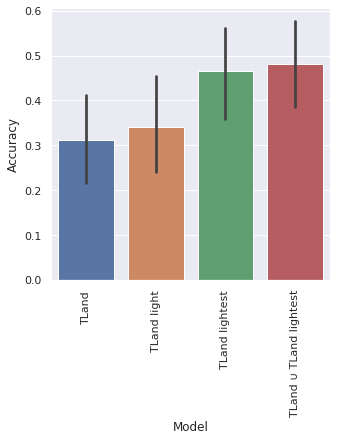

In [32]:
#Select GWAS traits_final_modifiedByTlandAndLightestTest.csv
accuracy_results_df = pd.DataFrame(accuracy_results_ls, columns=['trait', 'method', 'accuracy', 'top_organs'])
print(accuracy_results_df.loc[(accuracy_results_df['method'] == method_selected[0]) | 
                                                                   (accuracy_results_df['method'] == 'tland_light_t_test_LD099_NoRefine') |
                                                                        (accuracy_results_df['method'] == method_selected[1]) |
                                                                        (accuracy_results_df['method'] == ','.join(method_selected))].groupby('method').mean())
sns.set(rc={'figure.figsize':(5,5)})

plt.figure()
ax = sns.barplot(x='method', y='accuracy', data=accuracy_results_df.loc[(accuracy_results_df['method'] == method_selected[0]) | 
                                                                   (accuracy_results_df['method'] == 'tland_light_t_test_LD099_NoRefine') |
                                                                        (accuracy_results_df['method'] == method_selected[1]) |
                                                                        (accuracy_results_df['method'] == ','.join(method_selected)), :])
plt.xlabel('Model')
plt.ylabel('Accuracy')
ax.set_xticklabels(['TLand', 'TLand light', 'TLand lightest', 'TLand ∪ TLand lightest'])
plt.xticks(rotation=90)
plt.savefig('../plots/accuracy_plot.svg', dpi=1300)

### 3. Trait enrichment

In [6]:
LD_pairs_keys = LD_paris.keys()
LD_variant_ext = {}
for gwas_variant in LD_paris:
    LD_variants = LD_paris[gwas_variant]
    for LD_variant in LD_variants:
        if LD_variant not in LD_pairs_keys:
            LD_variant_ext[LD_variant] = gwas_variant

In [10]:
# preprocessing to make sure we have all the keys
LD_pairs_ext_keys = LD_variant_ext.keys()
all_keys = list(LD_pairs_keys) + list(LD_pairs_ext_keys)
df_scores_tland_keys = df_scores_tland.loc[df_scores_tland['name'].isin(all_keys), :]
df_scores_tland_light_keys = df_scores_tland_light.loc[df_scores_tland_light['name'].isin(all_keys), :]
df_scores_tland_lightest_keys = df_scores_tland_lightest.loc[df_scores_tland_lightest['name'].isin(all_keys), :]

In [11]:
# calculate total count for each trait over all variants in df
print('finding all variants ...')
all_variants = []
for variant in df_scores_tland_keys['name']:
    if variant in LD_pairs_keys:
        all_variants.append(variant)
    elif variant in LD_pairs_ext_keys:
        all_variants.append(LD_variant_ext[variant])
    else:
        print(f"{variant} is not found.")
print('finish.')

print('finding all traits ...')
all_traits_temp = []
rsID_trait_keys = rsID_trait.keys()
for gwas_variant in all_variants:
    if gwas_variant in rsID_trait_keys:
        all_traits_temp.append(rsID_trait[gwas_variant]['Mapped_trait'])
    else:
        print(f"{gwas_variant} is not found.")
print('finish.')

all_traits_count = {}
for trait in all_traits_temp:
    trait_ls_temp = []
    for trait_ind in trait:
        for trait_sep in trait_ind.split(','):
            trait_ls_temp.append(trait_sep.strip())
    for element in set(trait_ls_temp):
        if element not in all_traits_count:
            all_traits_count[element] = 1
        else:
            all_traits_count[element] += 1

finding all variants ...
finish.
finding all traits ...
finish.


In [12]:
organ = 'nerve'
threshold = 0.8
model = df_scores_tland_lightest_keys
weighted = True

select organ nerve variant 4112 which is 0.20914926299299108 %
finding related gwas snps...
finish.
finding gwas traits...
finish.
finding total numbers ...
finish.


trait  nerve_0.8_counts  total  \
220                      renin measurement          0.822874      4   
701  LDL cholesterol:HDL cholesterol ratio          0.842250      7   
799                     alcohol withdrawal          0.802441      7   
544                        yang deficiency          0.831803      9   
795                kininogen-1 measurement          0.805402     11   
..                                     ...               ...    ...   
880                          platelet crit          0.833922   1813   
794                 response to paclitaxel          0.823230   1894   
886      monocyte percentage of leukocytes          0.833125   1997   
499                     cervical carcinoma          0.823706   2319   
973                      attempted suicide          0.802185   2855   

     percentage  
220    0.205719  
701    0.120321  
799    0.114634  
544    0.092423  
795    0.073218  
..          ...  
880    0.000460  
794    0.000435  
886    0.000417  
499    0.000355  
973    0.000281  

[1034 rows x 4 columns]

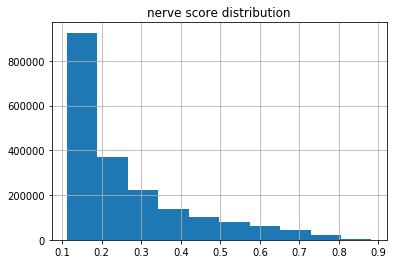

In [13]:
organ_top_scored_variant_scores = model.loc[model[organ] > threshold, organ].tolist()
organ_top_scored_variants = model.loc[model[organ] > threshold, 'name'].tolist()
model.loc[:, organ].hist()
plt.title(f'{organ} score distribution')
print(f"select organ {organ} variant {len(organ_top_scored_variant_scores)} which is {len(organ_top_scored_variant_scores)/model.shape[0]*100} %")

# find enriched gwas variants
print('finding related gwas snps...')
enriched_gwas_variants = []
LD_pairs_keys = LD_paris.keys()
for top_variant, variant_score in zip(organ_top_scored_variants, organ_top_scored_variant_scores):
    if top_variant in LD_pairs_keys:
        enriched_gwas_variants.append([top_variant, variant_score])
    elif top_variant in LD_pairs_ext_keys:
        enriched_gwas_variants.append([LD_variant_ext[top_variant], variant_score])
    else:
        print(f"{top_variant} is not found.")
print('finish.')

if weighted:
    # find enriched gwas traits
    print('finding gwas traits...')
    enriched_gwas_traits_temp = []
    rsID_trait_keys = rsID_trait.keys()
    for gwas_variant in enriched_gwas_variants:
        if gwas_variant[0] in rsID_trait_keys:
            enriched_gwas_traits_temp.append([rsID_trait[gwas_variant[0]]['Mapped_trait'], gwas_variant[1]])
        else:
            print(f"{gwas_variant} is not found.")
    print('finish.')

    enriched_gwas_traits = {}
    for trait in enriched_gwas_traits_temp:
        trait_ls_temp = []
        for trait_ind in trait[0]:
            for trait_sep in trait_ind.split(','):
                trait_ls_temp.append(trait_sep.strip())
        for element in set(trait_ls_temp):
            if element not in enriched_gwas_traits:
                enriched_gwas_traits[element] = trait[1]
            else:
                enriched_gwas_traits[element] += trait[1]
    
else:
    # find enriched gwas traits without weights
    print('finding gwas traits...')
    enriched_gwas_traits_temp = []
    rsID_trait_keys = rsID_trait.keys()
    for gwas_variant in enriched_gwas_variants:
        if gwas_variant[0] in rsID_trait_keys:
            enriched_gwas_traits_temp.append(rsID_trait[gwas_variant[0]]['Mapped_trait'])
        else:
            print(f"{gwas_variant} is not found.")
    print('finish.')

    enriched_gwas_traits = {}
    # enriched_gwas_traits = []
    for trait in enriched_gwas_traits_temp:
        trait_ls_temp = []
        for trait_ind in trait:
            for trait_sep in trait_ind.split(','):
                trait_ls_temp.append(trait_sep.strip())
    #     enriched_gwas_traits+=list(set(trait_ls_temp))
    # enriched_gwas_traits = dict(Counter(enriched_gwas_traits))
        for element in set(trait_ls_temp):
            if element not in enriched_gwas_traits:
                enriched_gwas_traits[element] = 1
            else:
                enriched_gwas_traits[element] += 1
    
    # enriched_gwas_traits = []
    # for trait in enriched_gwas_traits_temp:
    #     for trait_ind in trait.split(','):
    #         enriched_gwas_traits.append(trait_ind.strip())
    # enriched_gwas_traits = dict(Counter(enriched_gwas_traits))

# calibrate gwas traits based on total number
print('finding total numbers ...')
all_traits_count_keys = all_traits_count.keys()
enriched_gwas_traits_ls = []
for trait in enriched_gwas_traits:
    if trait in all_traits_count_keys:
        enriched_gwas_traits_ls.append([trait, enriched_gwas_traits[trait], int(all_traits_count[trait]),enriched_gwas_traits[trait]/int(all_traits_count[trait])])
    else:
        print(f"{trait} is not found.")
print('finish.')

organ_df = pd.DataFrame(enriched_gwas_traits_ls, columns=['trait', f'{organ}_{threshold}_counts', 'total', 'percentage']).sort_values(['percentage'], ascending=False)
organ_df

In [75]:
organ_df.to_csv('../data/tolookat.csv')

In [14]:
def horizontal_bar_labels(categories, color="#7030a0"):
    subplots = make_subplots(
        rows=len(categories),
        cols=1,
        subplot_titles=[x["name"] for x in categories],
        shared_xaxes=True,
        print_grid=False,
        vertical_spacing=(0.35 / len(categories)),
    )
    subplots['layout'].update(
        width=550,
        plot_bgcolor='#fff',
    )

    # add bars for the categories
    for k, x in enumerate(categories):
        subplots.add_trace(dict(
            type='bar',
            orientation='h',
            y=[x["name"]],
            x=[x["value"]],
            text=["{:,.3f}".format(x["value"])],
            hoverinfo='text',
            textposition='auto',
            marker=dict(
                # color="#7030a0",
                color=color,
            ),
        ), k+1, 1)

    # update the layout
    subplots['layout'].update(
        showlegend=False,
    )
    for x in subplots["layout"]['annotations']:
        x['x'] = 0
        x['xanchor'] = 'left'
        x['align'] = 'left'
        x['font'] = dict(
            size=14,
        )

    # hide the axes
    for axis in subplots['layout']:
        if axis.startswith('yaxis'):# or axis.startswith('xaxis'):
            subplots['layout'][axis]['visible'] = False

    # update the margins and size
    subplots['layout']['margin'] = {
        'l': 0,
        'r': 0,
        't': 20,
        'b': 1,
    }
    height_calc = 45 * len(categories)
    height_calc = max([height_calc, 350])
    subplots['layout']['height'] = height_calc
    subplots['layout']['width'] = height_calc

    return subplots

In [15]:
threshold = 4800
plot_df = organ_df.loc[organ_df['total']>threshold, :].head(30).reset_index(drop=True)
plot_df

trait  nerve_0.8_counts  total  \
0                          brain volume measurement         28.571321   9828   
1                                 migraine disorder         13.098175   4887   
2                            appendicular lean mass         13.939831   5364   
3                  intraocular pressure measurement         20.346067   7960   
4                               response to vaccine         12.338388   4888   
5                    apolipoprotein A 1 measurement         12.220543   4915   
6                                         psoriasis         14.690473   6047   
7                            chronic kidney disease         13.074962   5566   
8                           systolic blood pressure         68.028566  28977   
9               serum IgG glycosylation measurement         18.782005   8211   
10                               multiple sclerosis         18.792049   8232   
11                          hair colour measurement         15.562373   6837   
12                       pulse pressure measurement         30.457290  13520   
13                         diastolic blood pressure         36.053374  16108   
14                               parental longevity         10.602636   4863   
15                  alcohol consumption measurement         18.847097   8859   
16                               ulcerative colitis         13.089853   6235   
17                red blood cell distribution width         27.749201  13389   
18                              Parkinson's disease         11.439186   5571   
19                        heel bone mineral density         78.610263  38749   
20                              balding measurement         30.277192  15019   
21                        Abnormality of refraction         16.295130   8136   
22                                      body height        131.876666  66161   
23                                colorectal cancer         17.981783   9062   
24                                 smoking behavior         30.004509  15269   
25                               smoking initiation          9.777553   4982   
26                                    FEV/FEC ratio         47.602989  24791   
27                                  body mass index        119.286343  62941   
28  low density lipoprotein cholesterol measurement         19.693991  10429   
29                     refractive error measurement          9.848887   5241   

    percentage  
0     0.002907  
1     0.002680  
2     0.002599  
3     0.002556  
4     0.002524  
5     0.002486  
6     0.002429  
7     0.002349  
8     0.002348  
9     0.002287  
10    0.002283  
11    0.002276  
12    0.002253  
13    0.002238  
14    0.002180  
15    0.002127  
16    0.002099  
17    0.002073  
18    0.002053  
19    0.002029  
20    0.002016  
21    0.002003  
22    0.001993  
23    0.001984  
24    0.001965  
25    0.001963  
26    0.001920  
27    0.001895  
28    0.001888  
29    0.001879

In [16]:
refactor = 100
index_ls = [0, 1, 10, 15, 18]
data = [{"name": plot_df.loc[index_num, 'trait'], "value": plot_df.loc[index_num, 'percentage']*refactor} for index_num in index_ls]

In [17]:
plotly_plot = horizontal_bar_labels(categories=data, color='blue')
plotly_plot
# plotly_plot.write_image(f'../plots/{organ}.png')